In [11]:
from flowermd.library import PPS, OPLS_AA_PPS
from flowermd.base import Pack,  Simulation
import hoomd

import numpy as np
import gsd.hoomd

import warnings
warnings.filterwarnings('ignore')

In [18]:
num_mols = 200

## Initialize the rigid frame (run once only if num_mols changed)

In [19]:
pps = PPS(num_mols=num_mols, lengths=1)
system = Pack(molecules=pps, density=0.9, packing_expand_factor=7)
system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True, remove_charges=True, scale_charges=True, remove_hydrogens=True)
pps_ff = system.hoomd_forcefield

No charged group detected, skipping electrostatics.


In [20]:
system.to_gsd("assets/pps_aa_N{}.gsd".format(num_mols))

In [21]:

aa_frame = gsd.hoomd.open("assets/pps_aa_N{}.gsd".format(num_mols))[0]
positions = aa_frame.particles.position
# indices of constituent particles
constituent_indx = [np.arange(7) + (i*7) for i in range(num_mols) ]


com_mass = []
com_positions = []

for indx in constituent_indx:
    total_mass = np.sum(aa_frame.particles.mass[indx])
    com_mass.append(total_mass)
    com_positions.append(
                np.sum(
                    aa_frame.particles.position[indx]
                    * aa_frame.particles.mass[indx, np.newaxis],
                    axis=0,
                )
                / total_mass
            )


rel_const_pos =  positions[constituent_indx[0]] - com_positions[0]

In [22]:
const_particle_types = list(np.asarray(aa_frame.particles.types)[list(aa_frame.particles.typeid)][constituent_indx[0]])

In [24]:
L = system.hoomd_snapshot.configuration.box[0]
L

66.86016

In [25]:
sample_rigid_lattice = gsd.hoomd.open('assets/pps_rigid_lattice_100.gsd')[0]
I = sample_rigid_lattice.particles.moment_inertia[0]
I

array([0.7980529 , 0.88629776, 0.18916835], dtype=float32)

In [26]:
# create the init rigid lattice

rigid_frame = gsd.hoomd.Frame()
rigid_frame.particles.types = ['rigid', 'ca', 'sh']

N_rigid = len(com_mass)
rigid_frame.particles.N = N_rigid
rigid_frame.particles.position = com_positions
rigid_frame.particles.typeid = [0] * N_rigid
rigid_frame.configuration.box = [L, L, L, 0, 0, 0]
rigid_frame.particles.mass = com_mass
rigid_frame.particles.moment_inertia = np.tile(I, (N_rigid, 1))
rigid_frame.particles.orientation = [(1, 0, 0, 0)] * N_rigid

rigid = hoomd.md.constrain.Rigid()
rigid.body['rigid'] = {
    "constituent_types":const_particle_types,
    "positions": rel_const_pos,
    "orientations": [(1.0, 0.0, 0.0, 0.0)]* len(rel_const_pos),
    }
simulation = hoomd.Simulation(device=hoomd.device.CPU(), seed=4)
simulation.create_state_from_snapshot(rigid_frame)

rigid.create_bodies(simulation.state)
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
integrator.rigid = rigid
simulation.operations.integrator = integrator
simulation.run(0)

hoomd.write.GSD.write(state=simulation.state, mode='wb', filename='assets/pps_rigid_lattice_{}.gsd'.format(num_mols))

In [27]:
N_rigid

200

In [28]:
target_box_size = system.target_box
target_box_size[0]

9.551451765868338

### Run rigid simulations

In [29]:
def create_rigid_simulation(kT, num_mols):
    rigid_simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=1)
    rigid_simulation.create_state_from_gsd(filename='assets/pps_rigid_lattice_{}.gsd'.format(num_mols))
    const_particle_types = list(np.asarray(aa_frame.particles.types)[list(aa_frame.particles.typeid)][constituent_indx[0]])

    rigid = hoomd.md.constrain.Rigid()
    rigid.body['rigid'] = {
        "constituent_types":const_particle_types,
        "positions": rel_const_pos,
        "orientations": [(1.0, 0.0, 0.0, 0.0)]* len(rel_const_pos),
        }
    integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
    rigid_simulation.operations.integrator = integrator
    integrator.rigid = rigid
    rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
    nvt = hoomd.md.methods.ConstantVolume(
        filter=rigid_centers_and_free,
        thermostat=hoomd.md.methods.thermostats.Bussi(kT=kT))
    integrator.methods.append(nvt)
    
    cell = hoomd.md.nlist.Cell(buffer=0, exclusions=['body'])
    
    lj = hoomd.md.pair.LJ(nlist=cell)
    
    # use aa pps simulation to define lj and special lj forces between constituent particles
    for k, v in dict(pps_ff[0].params).items():
        lj.params[k] = v
        lj.r_cut[k] = 2.5
    
    lj.params[('rigid', ['rigid', 'ca', 'sh'])]= dict(epsilon=0, sigma=0)
    lj.r_cut[('rigid', ['rigid', 'ca', 'sh'])] = 0

    integrator.forces.append(lj)
    rigid_simulation.state.thermalize_particle_momenta(filter=rigid_centers_and_free,
                                             kT=kT)
    
    rigid_simulation.run(0)

    
    log_quantities = [
                        "kinetic_temperature",
                        "potential_energy",
                        "kinetic_energy",
                        "volume",
                        "pressure",
                        "pressure_tensor",
                    ]
    logger = hoomd.logging.Logger(categories=["scalar", "string", "particle"])
    logger.add(rigid_simulation, quantities=["timestep", "tps"])
    thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    rigid_simulation.operations.computes.append(thermo_props)
    logger.add(thermo_props, quantities=log_quantities)
    
    # for f in integrator.forces:
    #     logger.add(f, quantities=["energy", "forces", "energies"])

    logger.add(rigid_simulation.operations.integrator.rigid, quantities=["torques", "forces", "energies"])
    
    gsd_writer = hoomd.write.GSD(
        filename="logs/pps_{}/trajectory_{}.gsd".format(num_mols, kT),
        trigger=hoomd.trigger.Periodic(int(100)),
        mode="wb",
        logger=logger,
        filter=hoomd.filter.All(),
        dynamic=["momentum", "property"]
        )
    
    rigid_simulation.operations.writers.append(gsd_writer)

    table_logger = hoomd.logging.Logger(categories=["scalar", "string"])
    table_logger.add(rigid_simulation, quantities=["timestep", "tps"])
    table_logger.add(thermo_props, quantities=log_quantities)
    table_file = hoomd.write.Table(
            output=open("logs/pps_{}/log_{}.txt".format(num_mols, kT), mode="w", newline="\n"),
            trigger=hoomd.trigger.Periodic(int(100)),
            logger=table_logger,
            max_header_len=None,
        )
    rigid_simulation.operations.writers.append(table_file)
    return rigid_simulation

def run_displacement_cap(simulation, n_steps):
    
    rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
    simulation.operations.integrator.methods = [hoomd.md.methods.DisplacementCapped(filter=rigid_centers_and_free, 
                                                                                         maximum_displacement=1e-3)]
    simulation.run(n_steps)
    
def shrink_volume(simulation, kT, target_box, n_steps):
    rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
    nvt = hoomd.md.methods.ConstantVolume(filter=rigid_centers_and_free, thermostat=hoomd.md.methods.thermostats.Bussi(kT=kT))
    simulation.operations.integrator.methods = [nvt]
    # box resizer
    final_box = hoomd.Box(
            Lx=target_box,
            Ly=target_box,
            Lz=target_box,
        )
    resize_trigger = hoomd.trigger.Periodic(100)
    box_ramp = hoomd.variant.Ramp(
        A=0, B=1, t_start=simulation.timestep, t_ramp=int(n_steps)
    )
    initial_box = simulation.state.box

    box_resizer = hoomd.update.BoxResize(
        box1=initial_box,
        box2=final_box,
        variant=box_ramp,
        trigger=resize_trigger,
    )
    simulation.operations.updaters.append(box_resizer)
    simulation.run(n_steps + 1, write_at_start=True)
    simulation.operations.updaters.remove(box_resizer)

    
    

In [30]:
kT_list = [0.5, 7.0, 8.0, 9.0, 10.0]
for kT in kT_list:
    print(kT)
    rigid_simulation = create_rigid_simulation(kT, num_mols=num_mols)
    run_displacement_cap(rigid_simulation, 1e4)
    rigid_simulation.operations.writers[0].flush()
    print('displacement cap run done')
    shrink_volume(rigid_simulation, kT, target_box=target_box_size[0], n_steps=1e4)
    rigid_simulation.operations.writers[0].flush()
    print('shrink done')
    rigid_simulation.run(1e5)
    rigid_simulation.operations.writers[0].flush()

0.5
displacement cap run done
shrink done
7.0
displacement cap run done
shrink done
8.0
displacement cap run done
shrink done
9.0
displacement cap run done
shrink done
10.0
displacement cap run done
shrink done


In [31]:
snap = rigid_simulation.state.get_snapshot()
snap.particles.N

1600

## Check potential Energies

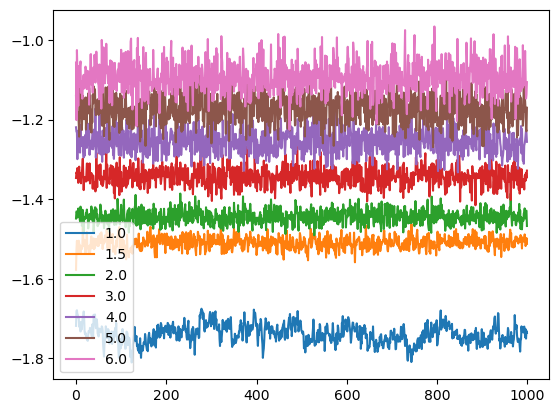

In [45]:
import numpy as np
import matplotlib.pyplot as plt

for kT in kT_list:
    log = np.genfromtxt("logs/pps_{}/log_{}.txt".format(num_mols, kT), names=True)
    potential_energy = log['mdcomputeThermodynamicQuantitiespotential_energy'][-1000:]/1600.
    plt.plot(potential_energy, label=kT)
plt.legend()

In [50]:
log.shape

(1201,)

## Read trajectories and gather samples

In [48]:
all_frames = []
for kT in kT_list:
    traj = gsd.hoomd.open("logs/pps_{}/trajectory_{}.gsd".format(num_mols, kT))
    for frame in traj[-1000:]:
        all_frames.append(frame)

In [49]:
len(all_frames)

7000

In [51]:
zero_energy_frames = []
for i, f in enumerate(all_frames):
    if f.log['md/compute/ThermodynamicQuantities/potential_energy'][0] == 0:
        zero_energy_frames.append(i)

In [52]:
len(zero_energy_frames)

0

In [53]:
L = all_frames[0].configuration.box[0]
L

9.551452

In [82]:
import freud
def find_neighbors(points, L, NN=15):
    box = freud.box.Box.cube(L)
    aq = freud.locality.AABBQuery(box, points)

    query_points = points
    query_result = aq.query(query_points, dict(num_neighbors=NN, exclude_ii=True))
    nlist = query_result.toNeighborList()
    neighbor_list = np.asarray(list(zip(nlist.query_point_indices, nlist.point_indices)))
    return neighbor_list
    
    

## Creating dataset

In [83]:
N_rigid

200

In [84]:
positions = []
neighbor_lists = []
orientations = []
forces = []
torques = []
energies = []
for frame in all_frames:
    frame_positions = frame.particles.position[:N_rigid]
    neighbor_lists.append(find_neighbors(frame_positions,L=L))
    positions.append(frame_positions)
    orientations.append(frame.particles.orientation[:N_rigid])
    forces.append(frame.log['particles/md/constrain/Rigid/forces'][:N_rigid])
    torques.append(frame.log['particles/md/constrain/Rigid/torques'][:N_rigid])
    energies.append(frame.log['particles/md/constrain/Rigid/energies'][:N_rigid])

In [85]:
import rowan
orientations_R = rowan.to_matrix(orientations)

In [86]:
import pandas as pd
columns = [
    "position",
    "orientation_q",
    "orientation_R", 
    "force",
    "torque",
    "energy",
    "neighbor_list"
]

new_traj_df = pd.DataFrame(columns=columns)
new_traj_df["position"] =positions
new_traj_df["orientation_q"] = orientations
new_traj_df["orientation_R"] = orientations_R.tolist()
new_traj_df["force"] = forces
new_traj_df["torque"] = torques
new_traj_df["energy"] = energies
new_traj_df["neighbor_list"] = neighbor_lists

In [87]:
new_traj_df.head()

,position,orientation_q,orientation_R,force,torque,energy,neighbor_list
0,"[[0.7437024, 3.4247556, 1.3543376], [-2.839805...","[[0.24504165, -0.3628349, 0.21626392, -0.87265...","[[[-0.6166108846664429, 0.2707398533821106, 0....","[[-16.36104830711689, -26.127665013767874, -3....","[[5.622786352779684, -1.3516238765429265, -2.6...","[-14.257601692361774, -13.865592325787588, -8....","[[0, 13], [0, 25], [0, 26], [0, 27], [0, 30], ..."
1,"[[0.42468178, 3.3085976, 0.94320613], [-2.8891...","[[0.2984936, -0.2594815, 0.082272545, -0.91476...","[[[-0.6871418952941895, 0.5034089088439941, 0....","[[13.613522734508138, -13.273965102090848, 7.2...","[[4.772125399941038, -11.360529844096762, -12....","[-12.48955151363856, -15.063771259450856, -10....","[[0, 8], [0, 15], [0, 25], [0, 26], [0, 27], [..."
2,"[[0.20104322, 3.4662402, 0.86697423], [-3.0276...","[[0.026435956, 0.28017688, -0.1589674, -0.9463...","[[[-0.8416042327880859, -0.03904395550489426, ...","[[-2.289652974308554, -1.134351376926971, 13.9...","[[2.069690631115769, 6.25820486064316, 0.53259...","[-10.787450786706573, -14.408041472996544, -11...","[[0, 15], [0, 25], [0, 26], [0, 27], [0, 40], ..."
3,"[[0.1527749, 3.3787022, 0.86001813], [-3.08905...","[[0.07544304, 0.2471812, -0.38352737, -0.88663...","[[[-0.8664195537567139, -0.05582106113433838, ...","[[39.21292753865415, 33.97719337374402, 17.070...","[[-1.5015990752140937, -12.826124025995385, 28...","[-10.556310392504434, -14.066282731169876, -12...","[[0, 15], [0, 18], [0, 25], [0, 26], [0, 27], ..."
4,"[[0.18621239, 3.6488562, 0.7711219], [-2.82507...","[[0.33000478, 0.2368554, -0.30533072, -0.86126...","[[[-0.6699926853179932, 0.4238016605377197, -0...","[[13.027524266535782, -1.7607741941373036, 9.8...","[[1.2742423847506106, -5.055086796640651, -0.8...","[-10.86980297782932, -13.071520019700113, -11....","[[0, 14], [0, 15], [0, 25], [0, 26], [0, 27], ..."


In [88]:
new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)# shuffle dataset

In [89]:
new_traj_df.head()

,position,orientation_q,orientation_R,force,torque,energy,neighbor_list
0,"[[0.3291067, -0.32625458, -0.9405715], [-4.024...","[[0.7158976, -0.52559125, 0.33519274, -0.31446...","[[[0.5775110721588135, 0.09790533781051636, 0....","[[-21.11601275698156, -12.245332400161846, -4....","[[-0.5255690432481679, 0.039487054352458806, 3...","[-16.421791759395322, -16.672936087486388, -15...","[[0, 10], [0, 11], [0, 28], [0, 48], [0, 72], ..."
1,"[[2.937887, -1.6287135, 2.441588], [-1.2227695...","[[-0.04692211, -0.9273857, -0.3174794, 0.19225...","[[[0.7244918942451477, 0.6068934202194214, -0....","[[-1.426185453235588, 0.7459653171815672, -7.0...","[[-6.499786341529129, 5.888952298788228, -6.47...","[-6.84574567633367, -15.67599061060152, -15.53...","[[0, 16], [0, 44], [0, 77], [0, 86], [0, 100],..."
2,"[[-2.7110002, -1.7037761, -0.28764296], [4.466...","[[0.66430384, -0.65854603, 0.25980932, 0.23982...","[[[0.7499648928642273, -0.6608278751373291, 0....","[[-14.312572208153568, -30.101989005586102, 10...","[[11.143203107689347, 12.64134818640504, 6.445...","[-11.405929512487141, -5.97595002330566, -1.60...","[[0, 15], [0, 24], [0, 35], [0, 40], [0, 55], ..."
3,"[[4.5961456, -4.090287, -4.3196125], [-2.16138...","[[-0.5936441, 0.6372696, -0.48501068, -0.07898...","[[[0.5170517563819885, -0.7119438052177429, 0....","[[-83.21903738177122, 33.34091720836907, -53.6...","[[-6.16236860615393, -5.4122435477704744, -26....","[-9.559556083815146, -9.82643727754488, -9.716...","[[0, 41], [0, 48], [0, 54], [0, 57], [0, 67], ..."
4,"[[-0.63997537, -1.9282506, 4.7199116], [-4.436...","[[0.69005525, 0.11322401, 0.0986222, 0.7080097...","[[[-0.022008180618286133, -0.9547988772392273,...","[[24.20004441822409, 26.1548685815659, 12.2905...","[[12.056608079865239, 0.324643601096278, -8.30...","[-10.835641152135631, -14.426346303869568, -11...","[[0, 24], [0, 25], [0, 33], [0, 47], [0, 50], ..."


In [90]:
import os
target_datapath="/home/marjanalbooyeh/Aniso_ML_MD_project/ml_datasets/pps_200"

new_traj_df.to_pickle(os.path.join(target_datapath, "raw.pkl"))
test_frac = 0.1
val_frac = 0.1

dataset_len = new_traj_df.shape[0]
test_len = int(dataset_len * test_frac)
val_len = int(dataset_len * val_frac)

test_df = new_traj_df.iloc[:test_len]

val_df = new_traj_df.iloc[test_len: test_len + val_len]

train_df = new_traj_df.iloc[test_len + val_len:]


In [91]:
train_df.to_pickle(os.path.join(target_datapath, 'train.pkl'))
val_df.to_pickle(os.path.join(target_datapath, 'val.pkl'))
test_df.to_pickle(os.path.join(target_datapath, 'test.pkl'))